In [1]:
import numpy as np
import pandas as pd 
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision import transforms
from torch.utils import data
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import time
import copy
import gc

In [2]:
data_dir = os.path.join('..','input','sign_data','sign_data')
train_df = pd.read_csv(os.path.join(data_dir,'train_data.csv'),header = None)
test_df = pd.read_csv(os.path.join(data_dir,'test_data.csv'),header = None)

In [3]:
from sklearn.model_selection import train_test_split
test_labels = test_df.iloc[:,2]
val_df,test_df = train_test_split(test_df,test_size = 0.30,stratify = test_labels)

In [4]:
train_df.head(3)

,0,1,2
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1


In [5]:
test_df.sample(3)

,0,1,2
801,058/04_058.png,058/10_058.png,0
5652,066/07_066.png,066/09_066.png,0
3358,060/04_060.png,060_forg/01_0121060.PNG,1


In [6]:
val_df.sample(3)

,0,1,2
3328,060/12_060.png,060_forg/02_0121060.PNG,1
3868,054/05_054.png,054_forg/01_0214054.PNG,1
5049,064/04_064.png,064/05_064.png,0


In [7]:
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test')

In [8]:
data_transforms = transforms.Compose([
        transforms.Resize((105,105)),
        transforms.ToTensor(),
    ])

In [9]:
from torch.utils import data
class GetData(data.Dataset):
    def __init__(self,df,dirpath,transforms):
        self.df = df
        self.dirpath = dirpath
        self.transforms = transforms
        self.len = len(df)
        self.image_arr1 = np.array(self.dirpath+'/'+self.df.iloc[:,0])
        self.image_arr2 = np.array(self.dirpath+'/'+self.df.iloc[:,1])
        self.target = np.array(self.df.iloc[:,2])
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        img1,img2 = self.image_arr1[idx],self.image_arr2[idx]
        img1,img2 = Image.open(img1),Image.open(img2)
        img1,img2 = img1.convert("L"),img2.convert("L")
        trans_img1,trans_img2 = self.transforms(img1),self.transforms(img2)
        self.label = torch.tensor(self.target[idx],dtype=torch.float32)
        return (trans_img1,trans_img2 ),self.label

In [10]:
train_dataset = GetData(train_df,train_dir,data_transforms)
val_dataset = GetData(val_df,test_dir,data_transforms)
test_dataset = GetData(test_df,test_dir,data_transforms)

In [11]:
train_loader = data.DataLoader(dataset=train_dataset,batch_size= 64,shuffle = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size= 64,shuffle = True)
val_loader = data.DataLoader(dataset=val_dataset,batch_size= 64,shuffle = True)

In [12]:
(img1,img2), labels = next(iter(test_loader))
print(img1.shape,img2.shape,labels.shape)

torch.Size([64, 1, 105, 105]) torch.Size([64, 1, 105, 105]) torch.Size([64])


In [13]:
dataloader_dict = {'train':train_loader,'val': val_loader,'test':test_loader}

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
def plot_grid(concat_batch,labels,n_rows,space):
    plt.figure(figsize=(16,2))
    plt.axis("off")
    joiner = ' '* space
    x = joiner.join(list(map(str,labels)))
    plt.title(x)
    plt.imshow(np.transpose(vutils.make_grid(concat_batch,
                                         nrow=n_rows, 
                                         padding=2, 
                                         normalize=True),(1,2,0)))

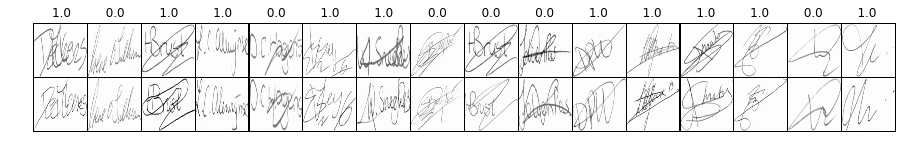

In [16]:
train_batch = next(iter(train_loader))
concat_tensor = torch.cat((train_batch[0][0][16:32],train_batch[0][1][16:32]),0)
labels = train_batch[1][16:32].tolist()
plot_grid(concat_tensor,labels,16,9)

In [17]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential( 
        nn.Conv2d(1, 96, kernel_size=11,stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),

        nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
        nn.Linear(30976, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256,128))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, image1, image2):
        return self.forward_once(image1),self.forward_once(image2)

In [18]:
model = SiameseNeuralNetwork()
len(dataloader_dict['train'].dataset)

23206

In [19]:
assert len(train_df) == len(dataloader_dict['train'].dataset)
assert len(val_df) == len(dataloader_dict['val'].dataset)
assert len(test_df) == len(dataloader_dict['test'].dataset)

In [20]:
def train_model(model,dataloader_dict,loss_function,optimizer,num_epochs= 30):
    best_loss =np.inf
    for epoch in range(num_epochs):
        print('Epoch: {}/{}'.format(epoch+1,num_epochs))
        for phase in ['train','val']:
            start_time = time.time()
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for images_batch,label_batch in tqdm(dataloader_dict[phase],disable =True):
                img1,img2 = images_batch[0].to(device),images_batch[1].to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output1,output2 = model(img1,img2)
                    
                    loss = loss_function(output1, output2,label_batch.to(device))
                
                if phase =='train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * img1.size(0)
            epoch_loss = running_loss/len(dataloader_dict[phase].dataset)
            
            if phase == 'val' and epoch_loss < best_loss:
                print("model val_loss Improved from {:.6f} to {:.6f}".format(best_loss,epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            elapsed_time = time.time()-start_time
            print("Phase: {} | {}_loss:{:.8f} | Time: {:.4f}s".format(phase,
                                                                      phase,
                                                                      epoch_loss,
                                                                      elapsed_time))
        print("******************************************************************")
    model.load_state_dict(best_model_wts)           
    return model
                

In [21]:
gc.collect()

2158

In [22]:
# images, labels = next(iter(train_loader))
model = model.to(device)
# img1,img2 = images[0].to(device),images[1].to(device)
# x = model(img1,img2)
# print(x[0].shape)
# print("  batch | vector_size")

In [23]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [24]:
optimizer = optim.Adam(model.parameters(),lr = 0.0005)
loss_fn = ContrastiveLoss() 
model = train_model(model,dataloader_dict,loss_fn,optimizer)

Epoch: 1/30
Phase: train | train_loss:0.83298776 | Time: 250.3769s
model val_loss Improved from inf to 0.374450
Phase: val | val_loss:0.37445017 | Time: 36.0732s
******************************************************************
Epoch: 2/30
Phase: train | train_loss:0.37206489 | Time: 247.1212s
model val_loss Improved from 0.374450 to 0.151534
Phase: val | val_loss:0.15153418 | Time: 35.4024s
******************************************************************
Epoch: 3/30
Phase: train | train_loss:0.10023053 | Time: 245.6071s
Phase: val | val_loss:0.18532148 | Time: 35.6011s
******************************************************************
Epoch: 4/30
Phase: train | train_loss:0.03950116 | Time: 245.8858s
model val_loss Improved from 0.151534 to 0.014779
Phase: val | val_loss:0.01477874 | Time: 35.5021s
******************************************************************
Epoch: 5/30
Phase: train | train_loss:0.06239577 | Time: 245.3867s
model val_loss Improved from 0.014779 to 0.006552
Ph

In [25]:
PATH = os.path.join(os.getcwd(),'model.pth')
torch.save(model.state_dict(),PATH)
gc.collect()

28

In [26]:
model.eval()
start, end = 16,32
(image1,image2),actual_label = next(iter(dataloader_dict['test']))
img1,img2 = image1.to(device),image2.to(device)
output1,output2 = model(img1,img2)
euclidean_distance = F.pairwise_distance(output1, output2)

In [27]:
actual_label = torch.as_tensor(actual_label,dtype = torch.int8)
actual_label = actual_label[start:end].tolist()
concat_tensor = torch.cat((image1[start:end],image2[start:end]),0)
labels = euclidean_distance[start:end].tolist()
labels = [0 if element<0.5 else 1 for element in labels]
labels = list(map(lambda x:str(x)[:3],labels))
new_labels = ['A:'+str(actual_label[i])+' P:' +str(labels[i]) for i in range(end-start)]

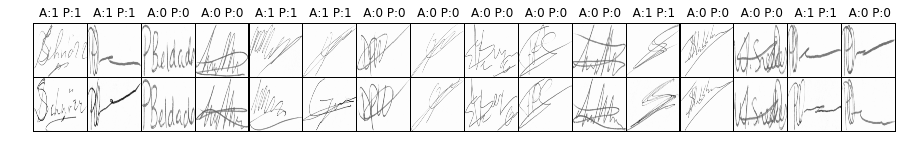

In [28]:
plot_grid(concat_tensor,new_labels,end-start,3)

In [29]:
# class CustomLoss(nn.Module):
#     def __init__(self, margin=2.0):
#         super(CustomLoss, self).__init__()
#         self.margin = margin
    
#     def forward(self, output1, output2, label):
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         cross_entropy = torch.nn.BCEWithLogitsLoss(euclidean_distance, label)
#         return cross_entropy

In [30]:
# optimizer = optim.Adam(model.parameters(),lr = 0.001)
# loss_fn = CustomLoss() 
# train_model(model,dataloader_dict,loss_fn,optimizer)